# TFM : Aplicación de *Machine Learning* para la Gestión de Inventarios
> Erendira Teresa Navarro García

Probar rangos de parámetros

In [ ]:
# Python 3 environment Google Colab
import pandas as pd
import os
import csv
import datetime as datetime
import pywt
import json 
import sklearn
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pylab as plab
from datetime import datetime
from dateutil.parser import parse
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate
from pickle import dump

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Lectura de datos

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
df_tfm = pd.read_csv('/content/drive/MyDrive/Files_TFM/export_data_tfm.csv', parse_dates=['fecha'], date_parser=dateparse, dtype={'sku': str})
#Prepare data
df_tfm = df_tfm.sort_values(by='fecha').set_index('fecha')

## Preparación de los datos

In [ ]:
# Función para creación de nuevas variables - lag de 1 a 7 y diferencia en ventas del día anterior y del día previo
def features(dataset_t, columns_y):
  for i in range(1,8):
    dataset_t.loc[:,'lag'+str(i)] = dataset_t.loc[:,columns_y].shift(i)
    if i in [1,2]:
      dataset_t.loc[:,'diff'+str(i)] = dataset_t.loc[:,columns_y].diff(i)
  # Eliminar NAs
  dataset_t = dataset_t.dropna()
  return dataset_t

# Separar dataset y crear nuevas variables
def split_dataset(dataset, split_per, column_y):
  data_train, data_test = train_test_split(dataset, test_size=split_per, shuffle=False)
  data_train_total = features(data_train,column_y)
  data_test_total = features(data_test,column_y)
  y_train = data_train_total.loc[:,column_y]
  X_train = data_train_total.drop(columns=column_y)
  y_test = data_test_total.loc[:,column_y]
  X_test = data_test_total.drop(columns=column_y)
  return X_train, X_test, y_train, y_test

## Prueba de parámetros

In [ ]:
# Variables a utilizar en los modelos
columns_ok = ["bolOpen","promo"]
columns_to_scale  = ['lag'+str(i) for i in [1,2,7]] + ['diff'+str(i) for i in [1,2]]
y_to_scale  = ["udsVentaT"]

In [ ]:
os.chdir("/content/drive/MyDrive/Files_TFM/")
print(os.getcwd())

/content/drive/MyDrive/Files_TFM


In [ ]:
tscv = TimeSeriesSplit(n_splits=8)
y_target = "udsVentaT"
rango_sku = range(1,51)

### max_features

In [ ]:
dict_review = {'max_features': range(1, 8)}
tabla = pd.DataFrame([])
for i in rango_sku:
  dataset_sku = df_tfm[(df_tfm["sku"] == str(i))].drop(columns=["udsStock","label",])
  X_train, X_test, y_train, y_test = split_dataset(dataset_sku, 0.3, y_target)
  mm_scaler = MinMaxScaler(feature_range = (0,1))
  mm_y_scaler = MinMaxScaler(feature_range = (0,1))
  # Scale y values
  y_train_array = mm_y_scaler.fit_transform(y_train.reset_index()[[y_target]]).ravel()
  y_test_array = mm_y_scaler.fit_transform(y_test.reset_index()[[y_target]]).ravel()
  # Scale and complete X values
  X_tmp  = mm_scaler.fit_transform(X_train.reset_index()[columns_to_scale]) 
  X_train_array = np.concatenate([X_tmp , X_train.reset_index()[columns_ok].values], axis=1)
  X_tmp_t  = mm_scaler.fit_transform(X_test.reset_index()[columns_to_scale]) 
  X_test_array = np.concatenate([X_tmp_t , X_test.reset_index()[columns_ok].values], axis=1)
  ####
  for k, v in dict_review.items():
    scores =[]
    for j in v:
      rfc = RandomForestRegressor(max_features = j)
      rfc.fit(X_train_array, y_train_array)
      scores.append(rfc.score(X_test_array,y_test_array))
    rango =  list(v)
    tab1 = pd.DataFrame({"valores":rango, "score":scores})
    tab1["sku"] = i
    tab1["param"] = "max_features"
    tabla = tabla.append(tab1,ignore_index=True)

### max_depth

In [ ]:
dict_review = {'max_depth': range(1, 26)}
for i in rango_sku:
  dataset_sku = df_tfm[(df_tfm["sku"] == str(i))].drop(columns=["udsStock","label"])
  X_train, X_test, y_train, y_test = split_dataset(dataset_sku, 0.3, y_target)
  mm_scaler = MinMaxScaler(feature_range = (0,1))
  mm_y_scaler = MinMaxScaler(feature_range = (0,1))
  # Scale y values
  y_train_array = mm_y_scaler.fit_transform(y_train.reset_index()[[y_target]]).ravel()
  y_test_array = mm_y_scaler.fit_transform(y_test.reset_index()[[y_target]]).ravel()
  # Scale and complete X values
  X_tmp  = mm_scaler.fit_transform(X_train.reset_index()[columns_to_scale]) 
  X_train_array = np.concatenate([X_tmp , X_train.reset_index()[columns_ok].values], axis=1)
  X_tmp_t  = mm_scaler.fit_transform(X_test.reset_index()[columns_to_scale]) 
  X_test_array = np.concatenate([X_tmp_t , X_test.reset_index()[columns_ok].values], axis=1)
  ####
  for k, v in dict_review.items():
    scores =[]
    for j in v:
      rfc = RandomForestRegressor(max_depth = j)
      rfc.fit(X_train_array, y_train_array)
      scores.append(rfc.score(X_test_array,y_test_array))
  rango =  list(v)
  tab1 = pd.DataFrame({"valores":rango, "score":scores})
  tab1["sku"] = i
  tab1["param"] = "max_depth"
  tabla = tabla.append(tab1,ignore_index=True)

### n_estimators

In [ ]:
dict_review = {'n_estimators': range(1,1210,50)}
for i in rango_sku:
  dataset_sku = df_tfm[(df_tfm["sku"] == str(i))].drop(columns=["udsStock","label"])
  X_train, X_test, y_train, y_test = split_dataset(dataset_sku, 0.3, y_target)
  mm_scaler = MinMaxScaler(feature_range = (0,1))
  mm_y_scaler = MinMaxScaler(feature_range = (0,1))
  # Scale y values
  y_train_array = mm_y_scaler.fit_transform(y_train.reset_index()[[y_target]]).ravel()
  y_test_array = mm_y_scaler.fit_transform(y_test.reset_index()[[y_target]]).ravel()
  # Scale and complete X values
  X_tmp  = mm_scaler.fit_transform(X_train.reset_index()[columns_to_scale]) 
  X_train_array = np.concatenate([X_tmp , X_train.reset_index()[columns_ok].values], axis=1)
  X_tmp_t  = mm_scaler.fit_transform(X_test.reset_index()[columns_to_scale]) 
  X_test_array = np.concatenate([X_tmp_t , X_test.reset_index()[columns_ok].values], axis=1)
  ####
  for k, v in dict_review.items():
    scores =[]
    for j in v:
      rfc = RandomForestRegressor(n_estimators = j)
      rfc.fit(X_train_array, y_train_array)
      scores.append(rfc.score(X_test_array,y_test_array))
  rango =  list(v)
  tab1 = pd.DataFrame({"valores":rango, "score":scores})
  tab1["sku"] = i
  tab1["param"] = "n_estimators"
  tabla = tabla.append(tab1,ignore_index=True)

### Gráficas

In [ ]:
%matplotlib inline

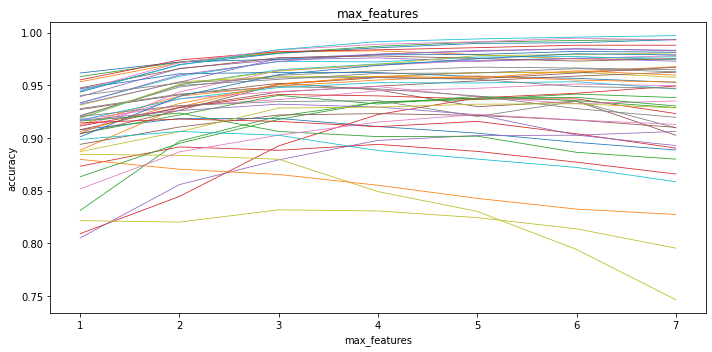

In [ ]:
plt.rcParams.update({'figure.figsize': (10,5)})
plt.subplots()
for i in range(1,51):
  plt.plot(tabla[(tabla["sku"] == i) & (tabla["param"] == "max_features")].set_index("valores")[["score"]], linewidth=0.8)
plt.xlabel('max_features')
plt.ylabel('accuracy')
plt.title("max_features")
plt.tight_layout()
plt.savefig("max_features.png", dpi=300, bbox_inches='tight')
#plt.close()

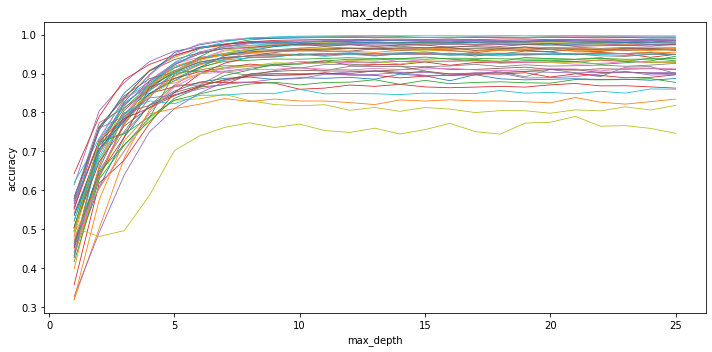

In [ ]:
plt.rcParams.update({'figure.figsize': (10,5)})
plt.subplots()
for i in range(1,51):
  plt.plot(tabla[(tabla["sku"] == i) & (tabla["param"] == "max_depth")].set_index("valores")[["score"]], linewidth=0.8)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("max_depth")
plt.tight_layout()
plt.savefig("max_depth.png", dpi=300, bbox_inches='tight')

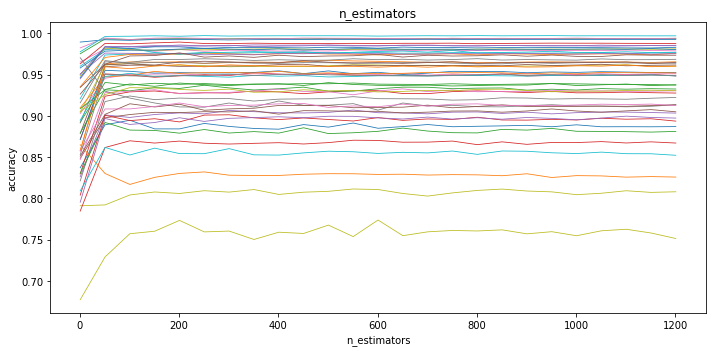

In [ ]:
plt.rcParams.update({'figure.figsize': (10,5)})
plt.subplots()
for i in range(1,51):
  plt.plot(tabla[(tabla["sku"] == i) & (tabla["param"] == "n_estimators")].set_index("valores")[["score"]], linewidth=0.8)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title("n_estimators")
plt.tight_layout()
plt.savefig("n_estimators.png", dpi=300, bbox_inches='tight')

In [ ]:
tabla.to_csv('tabla_revision_parametros_RF.csv', index=False)

In [ ]:
tabla_sku = tabla[tabla["param"] == "max_features"]
tabla_sku.loc[tabla_sku.reset_index().groupby(['sku'])['score'].idxmax()].groupby("valores")["sku"].count()

valores
1     2
2     3
3     8
4     8
5     3
6    15
7    11
Name: sku, dtype: int64

In [ ]:
tabla_sku = tabla[tabla["param"] == "max_depth"]
tabla_sku.iloc[tabla_sku.reset_index().groupby('sku')['score'].idxmax()].groupby("valores")["sku"].count()

valores
7     1
8     2
10    1
11    1
12    4
13    2
14    4
15    2
16    1
17    3
18    2
19    5
20    2
21    4
22    4
23    4
24    4
25    4
Name: sku, dtype: int64

In [ ]:
tabla_sku = tabla[tabla["param"] == "n_estimators"]
tabla_sku.iloc[tabla_sku.reset_index().groupby('sku')['score'].idxmax()].groupby("valores")["sku"].count()

valores
1       2
51      7
101     8
151     1
201     6
251     3
301     1
351     2
401     3
451     3
501     4
551     3
601     2
651     1
801     1
951     2
1101    1
Name: sku, dtype: int64

In [ ]:
tabla_sku[tabla_sku['score']<0.5]

,valores,score,sku,param
